In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#importing the libraries we may need
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms,datasets,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import shuffle


Using TensorFlow backend.


In [0]:
# workaround 
#this workaround is unnecessary if no error is shown on using PIL library
!pip install -U pillow
from PIL import Image
def register_extension(id, extension): 
  #Image.EXTENSION[extension.lower()] = id.upper()
  for i in range(len(extension)):
    Image.EXTENSION[extension[i].lower()]=id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extension

In [0]:
!kaggle datasets download -d smeschke/four-shapes

In [0]:
!unzip four-shapes.zip

In [0]:

!unzip shapes.zip


In [5]:
#fetching the image addresses 
#we will instantaneously read iamges tos ave cache space

imageset={x:glob(os.path.join(x,"*.png")) for x in ["circle","square","star","triangle"]}


print("No Of datapoints of Cirlce:{},Triangle:{},square:{},star:{}".format(len(imageset["circle"]),len(imageset["triangle"]),len(imageset["square"]),len(imageset["star"])))


No Of datapoints of Cirlce:3720,Triangle:3720,square:3765,star:3765


In [0]:
def display_images(imageset,figure,idx):
  img=plt.imread(imageset[figure][idx])
  plt.figure()
  plt.title(figure)
  plt.imshow(img)

In [0]:
labellist=["circle","star","square","triangle"]  #A list of our classes

In [8]:


trainimages,trainlabels,testimages,testlabels=[],[],[],[]
train_percent,to_train=.8,0  #For each class, 80% of the images will be usd for training and the rest for evaluation

for shape in ["circle","star","square","triangle"]:
  to_train=train_percent*len(imageset[shape])
  current_shape=imageset[shape]
  current_shape=shuffle(current_shape)  #we shuffle to increase generalization
   
  for i in range(len(imageset[shape])):
    
    if i<= to_train:
      
      trainimages.append(imageset[shape][i])
      trainlabels.append(shape)
    else:
      testimages.append(imageset[shape][i])
      testlabels.append(shape)
      
      
print("Size of trainset:{}".format(len(trainimages)))
print("Size of testset:{}".format(len(testimages)))



Size of trainset:11980
Size of testset:2990


In [0]:
traindataframe=pd.DataFrame({"image_name":trainimages,
                            "label":trainlabels
    
})

testdataframe=pd.DataFrame({"image_name":testimages,
                           "label":testlabels
                            
})


traindataframe=traindataframe.sample(frac=1).reset_index(drop=True)
testdataframe=testdataframe.sample(frac=1).reset_index(drop=True)


In [0]:
class create_dataset(Dataset):
  
  def __init__(self,dataframe,transform):
    self.df=dataframe
    self.transform=transform
    
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    img=self.df["image_name"].iloc[idx]
    label=self.df["label"].iloc[idx]
    img=Image.open(img)
    img=self.transform(img)
    label=np.asarray(labellist.index(label))     
    label=torch.as_tensor(label) #We are not one hot encoding because we want to Cross Entropy loss
                                    
      
    return img,label
  
    
    
    
    
    
    
    
  

In [0]:
tsfm_forimages=transforms.Compose([transforms.Resize((28,28)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   
                                   
    
]
)

traindataset=create_dataset(traindataframe,tsfm_forimages)
testdataset=create_dataset(testdataframe,tsfm_forimages)
    


In [0]:
batchsize=16
trainloader=DataLoader(dataset=traindataset,shuffle=True,batch_size=batchsize,num_workers=0)
testloader=DataLoader(dataset=testdataset,shuffle=True,batch_size=batchsize,num_workers=0)


In [0]:
class CNN_classifier(nn.Module):  #we define the model here
  
  def __init__(self):
    super(CNN_classifier,self).__init__()
    self.conv1=nn.Conv2d(1,6,5,1)
    #>>Maxpool Goes in here
    self.conv2=nn.Conv2d(6,16,5,1)
    #>>Maxpool Goes in here
    self.fc1=nn.Linear(256,128)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,4)
    
  def __call__(self,x):
    x=F.relu(self.conv1(x))
    x=F.max_pool2d(x,2,2)
    x=F.relu(self.conv2(x))
    x=F.max_pool2d(x,2,2)
    x=x.view(x.size(0),-1)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x))
    return x
  
    
 

In [34]:

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device="cpu"
print("Device being used:",device)
  
  
model=CNN_classifier()
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=.006,momentum=.9,weight_decay=1e-4)


Device being used: cuda:0


In [35]:
#here we train the model

m=len((trainloader))
n=len(testloader)
epochs=30
epochloss=list() #loss recorded per epoch is stored here


for epoch in range(epochs):
  batchloss_epoch=0.0
  
  for batchid,(x,y) in enumerate(trainloader):
    x,y=x.to(device),y.to(device)
    optimizer.zero_grad()
    out=model(x)
    
    loss=criterion(out,y)
    batchloss_epoch+=loss.item()
          
    loss.backward()
    optimizer.step()
    
  print("Loss For  epoch {}: {}".format(epoch,batchloss_epoch/m))
  epochloss.append(batchloss_epoch/m)
  
  
    


Loss For this epoch0:0.21870893420356555
Loss For this epoch1:0.0008927306494267113
Loss For this epoch2:0.00013191812983819734
Loss For this epoch3:7.836559798330838e-05
Loss For this epoch4:6.612627358931659e-05
Loss For this epoch5:5.8372072712621246e-05
Loss For this epoch6:5.046826338417858e-05
Loss For this epoch7:4.7909269134217325e-05
Loss For this epoch8:4.695400323790419e-05
Loss For this epoch9:4.309734133120691e-05
Loss For this epoch10:4.331835864350032e-05
Loss For this epoch11:4.145820033753235e-05
Loss For this epoch12:4.457727134307332e-05
Loss For this epoch13:4.1667758278260474e-05
Loss For this epoch14:4.222589861276359e-05
Loss For this epoch15:4.1980981085664255e-05
Loss For this epoch16:4.0671986689376014e-05
Loss For this epoch17:4.0525481814834635e-05
Loss For this epoch18:4.078016102871048e-05
Loss For this epoch19:4.033719798367499e-05
Loss For this epoch20:4.0926321060260735e-05
Loss For this epoch21:4.1018367396833984e-05
Loss For this epoch22:4.01605326801

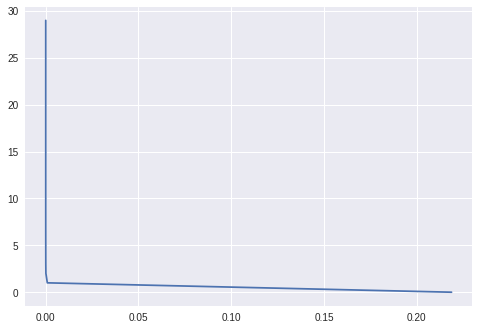

In [36]:
plt.plot(epochloss,range(epochs))

Label:tensor([3, 1, 1, 0, 0, 3, 2, 1, 2, 0, 2, 1, 3, 3, 0, 3], device='cuda:0'),Predicted:tensor([3, 1, 1, 0, 0, 3, 2, 1, 2, 0, 2, 1, 3, 3, 0, 3], device='cuda:0'),Loss:2.09808349609375e-05
Label:tensor([1, 1, 0, 1, 3, 3, 2, 0, 2, 0, 3, 0, 3, 0, 0, 2], device='cuda:0'),Predicted:tensor([1, 1, 0, 1, 3, 3, 2, 0, 2, 0, 3, 0, 3, 0, 0, 2], device='cuda:0'),Loss:6.198883056640625e-06
Label:tensor([1, 3, 1, 2, 1, 0, 3, 3, 3, 0, 3, 1, 0, 2, 1, 0], device='cuda:0'),Predicted:tensor([1, 3, 1, 2, 1, 0, 3, 3, 3, 0, 3, 1, 0, 2, 1, 0], device='cuda:0'),Loss:1.0848045349121094e-05
Label:tensor([2, 0, 3, 0, 2, 3, 0, 0, 3, 1, 0, 0, 3, 0, 3, 0], device='cuda:0'),Predicted:tensor([2, 0, 3, 0, 2, 3, 0, 0, 3, 1, 0, 0, 3, 0, 3, 0], device='cuda:0'),Loss:1.6450881958007812e-05
Label:tensor([3, 0, 0, 2, 1, 0, 3, 2, 1, 1, 3, 3, 1, 0, 2, 1], device='cuda:0'),Predicted:tensor([3, 0, 0, 2, 1, 0, 3, 2, 1, 1, 3, 3, 1, 0, 2, 1], device='cuda:0'),Loss:3.159046173095703e-05
Label:tensor([1, 3, 2, 3, 3, 0, 1, 2, 0, 0, 

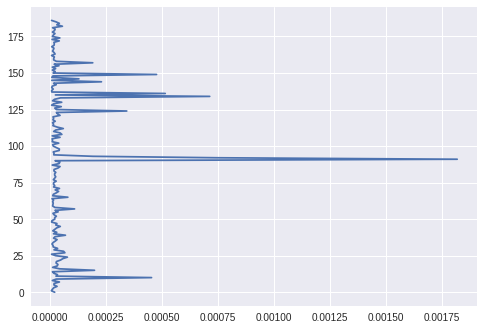

In [40]:
#now we test the model

with torch.no_grad():
  optimizer.zero_grad()
  correct=0
  total=0
  
  batchloss=list() #we store the loss per batch in this list
  
  for batchid,(xtest,ytest) in enumerate(testloader):
    
    xtest,ytest=xtest.to(device),ytest.to(device)
          
    pred=model(xtest)
    
    _,prediction=torch.max(pred.data,1)
    loss=criterion(pred,ytest)
    
    batchloss.append(loss.item())
    
    total+=ytest.size(0)
    correct+=(prediction==ytest).sum().item()
    print("Label:{},Predicted:{},Loss:{}".format(ytest,prediction,loss.item()))
    
  


 
    
    
  


In [43]:
print(100*(correct/total))
torch.save(model.state_dict(),"successfully_trained_model.ckpt")

100.0


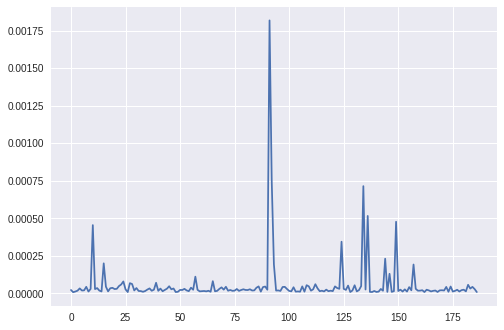

In [42]:
plt.plot(range(len(batchloss)),batchloss)